#### Funding

In [ ]:
def get_thresholds():
    data = []
    with open('./bot/config/thresholds.txt', 'r') as file:
        for line in file:
            line = line.strip()  # Удаляем пробелы и переносы строк
            if line:  # Игнорируем пустые строки
                # Преобразуем строку в кортеж с помощью literal_eval
                tuple_data = ast.literal_eval(line)
                data.append(tuple_data)
    return data

In [ ]:
from bot.core.exchange.http_api import ExchangeManager, BybitRestAPI, GateIORestAPI

import pandas as pd
import polars as pl
import numpy as np
# pd.options.display.float_format = '{:.2f}'.format
from datetime import datetime, timezone, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm

from bot.utils.files import get_saved_coins

In [ ]:
async def get_data(symbol, interval, n_iters, exchange):
    df = await exc_manager.get_candles(symbol=symbol, interval=interval, n_iters=n_iters)
    df = df[f'{exchange}_linear'].sort_index()
    return df.dropna()

In [ ]:
exc_manager = ExchangeManager()
exc_manager.add_market("bybit_linear", BybitRestAPI('linear'))
coin_information = exc_manager.get_instrument_data()

In [ ]:
exchange = 'bybit'

token_list = [
            '1INCH_USDT',
            'ACH_USDT', 'ADA_USDT', 'AGLD_USDT', 'ALGO_USDT', 'APT_USDT', 'ARB_USDT', 'ARKM_USDT', 'ATOM_USDT',
            'BLUR_USDT',
            'CELO_USDT', 'CHZ_USDT', 'CRV_USDT',
            'DOGE_USDT', 'DOT_USDT', 'DRIFT_USDT', 'DYDX_USDT',
            'EGLD_USDT', 'ENA_USDT', 'ETHFI_USDT', 'FARTCOIN_USDT', 'FLOW_USDT',
            'GALA_USDT', 'GLM_USDT', 'GMT_USDT', 'GRT_USDT',
            'HBAR_USDT', 'IMX_USDT', 'INJ_USDT', 'IOTA_USDT',
            'JASMY_USDT', 'JUP_USDT', 'KAS_USDT', 'KSM_USDT',
            'LDO_USDT', 'LPT_USDT',
            'MANA_USDT', 'MANTA_USDT', 'MORPHO_USDT', 'MOVE_USDT',
            'NEAR_USDT', 'NXPC_USDT',
            'ONDO_USDT', 'OP_USDT', 'ORDI_USDT',
            'PNUT_USDT', 'POL_USDT', 'RENDER_USDT', 'ROSE_USDT', 'RUNE_USDT',
            'S_USDT', 'SAND_USDT', 'SEI_USDT', 'STRK_USDT',
            'STX_USDT', 'SUI_USDT', 'SUSHI_USDT',
            'THETA_USDT', 'TIA_USDT', 'TON_USDT', 'TRX_USDT', 'VET_USDT',
            'WIF_USDT', 'XLM_USDT', 'XRP_USDT', 'ZRX_USDT'
              ]

syms = [col[:-5] for col in token_list]

In [ ]:
exc_manager = ExchangeManager()
exc_manager.add_market("bybit_linear", BybitRestAPI('linear'))

start_date = datetime.now().replace(microsecond=0) - timedelta(days=60)
end_date = None

for symbol in syms:
    fund_hist = await exc_manager.get_funding_history(symbol=f'{symbol}_USDT', start_date=start_date, limit=500)
    fund_hist = fund_hist[0]

    fund_sum = float(fund_hist['funding'].sum())
    fund_len = fund_hist['funding'].shape[0]

    hour_df = await get_data(symbol=f'{symbol}_USDT', interval='1h', n_iters=5, exchange=exchange)
    hour_df = hour_df.tail(4320) # Берём последние пол года
    hour_df.drop(['Exchange', 'Market_type'], axis=1, inplace=True)
    daily_df = await get_data(symbol=f'{symbol}_USDT', interval='1d', n_iters=1, exchange=exchange)
    daily_df = daily_df.tail(180) # Берём последние пол года

    hour_df['Max_range'] = hour_df['High'] - hour_df['Low']
    hour_df['Max_range_perc'] = (hour_df['High'] - hour_df['Low']) / hour_df['Low'] * 100
    hour_10 = hour_df[hour_df['Max_range_perc'] > 10].shape[0]
    hour_10_perc = 100 * hour_10 / hour_df.shape[0]
    hour_atr = hour_df['Max_range'].mean()
    hour_atr_perc = hour_df['Max_range_perc'].mean()
    hour_mtr_perc = hour_df['Max_range_perc'].max()

    daily_df['Max_range'] = daily_df['High'] - daily_df['Low']
    daily_df['Max_range_perc'] = (daily_df['High'] - daily_df['Low']) / daily_df['Low'] * 100
    days_10 = daily_df[daily_df['Max_range_perc'] > 10].shape[0]
    days_10_perc = 100 * days_10 / daily_df.shape[0]
    day_atr = daily_df['Max_range'].mean()
    day_atr_perc = daily_df['Max_range_perc'].mean()
    day_mtr_perc = daily_df['Max_range_perc'].max()

    print(f'========= {symbol} =========')
    print(f'Суммарный фандинг: {fund_sum * 100:.2f}%, расчётов по фандингу: {fund_len}')
    print(f'Фандинг. min: {fund_hist['funding'].min() * 100}%; max: {fund_hist['funding'].max() * 100}%')
    print()
    print(f'ATR за 1 день: {day_atr:.4f} ({day_atr_perc:.2f}%); за 1 час: {hour_atr:.4f} ({hour_atr_perc:.2f}%)')
    print(f'MaxTR за 1 день: {day_mtr_perc:.2f}%; за 1 час: {hour_mtr_perc:.2f}%')
    print(f'Колебания цены более 10%. Дни: {days_10} ({days_10_perc:.1f}%); Часы: {hour_10} ({hour_10_perc:.1f}%)')
    print()

In [ ]:
daily_df

#### Бектест одной торговой пары

In [1]:
from bot.analysis.pair_trading import backtest
from bot.utils.pair_trading import make_df_from_orderbooks, make_trunc_df, create_zscore_df
from bot.analysis.strategy_analysis import analyze_strategy

from datetime import datetime, timezone, timedelta
from zoneinfo import ZoneInfo
import polars as pl
import numpy as np
import pickle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['timezone'] = 'Europe/Moscow'

from bot.core.db.postgres_manager import DBManager
from bot.config.credentials import host, user, password, db_name
db_params = {'host': host, 'user': user, 'password': password, 'dbname': db_name}
db_manager = DBManager(db_params)

In [2]:
token_1 = 'IOTA'
token_2 = 'CELO'
min_order = 42

valid_length = 15
train_length = 5

end_time = datetime.now().replace(tzinfo=ZoneInfo("Europe/Moscow"))
valid_time = (end_time - timedelta(days=valid_length)).replace(hour=0, minute=0, second=0, microsecond=0)
start_time = valid_time - timedelta(days=train_length)
start_ts = int(datetime.timestamp(valid_time))

tf = '1h'
winds = np.array([48, 72, 96, 120])

with open("./data/coin_information.pkl", "rb") as f:
    coin_information = pickle.load(f)

dp_1 = float(coin_information['bybit_linear'][token_1 + '_USDT']['qty_step'])
ps_1 = int(coin_information['bybit_linear'][token_1 + '_USDT']['price_scale'])
dp_2 = float(coin_information['bybit_linear'][token_2 + '_USDT']['qty_step'])
ps_2 = int(coin_information['bybit_linear'][token_2 + '_USDT']['price_scale'])

In [3]:
df_1 = db_manager.get_tick_ob(token=token_1 + '_USDT',
                                     start_time=start_time,
                                     end_time=end_time)
df_2 = db_manager.get_tick_ob(token=token_2 + '_USDT',
                                     start_time=start_time,
                                     end_time=end_time)
print(f'{token_1:>8} first date: {df_1['time'][0]}')
print(f'{token_2:>8} first date: {df_2['time'][0]}')

df = make_df_from_orderbooks(df_1, df_2, token_1, token_2, start_time=start_time)
tick_df = make_df_from_orderbooks(df_1, df_2, token_1, token_2, start_time=start_time)

agg_df = make_trunc_df(df, timeframe=tf, token_1=token_1, token_2=token_2, method='triple')


dist_df = create_zscore_df(token_1, token_2, tick_df, agg_df, tf, winds, min_order, start_ts, 
                             median_length=6, spr_method='dist')
lr_df = create_zscore_df(token_1, token_2, tick_df, agg_df, tf, winds, min_order, start_ts, 
                             median_length=6, spr_method='lr')
tls_df = create_zscore_df(token_1, token_2, tick_df, agg_df, tf, winds, min_order, start_ts, 
                             median_length=6, spr_method='tls')

search_space = [(tf, int(w)) for w in winds]

    IOTA first date: 2025-10-30 00:00:00+03:00
    CELO first date: 2025-10-30 00:00:00+03:00


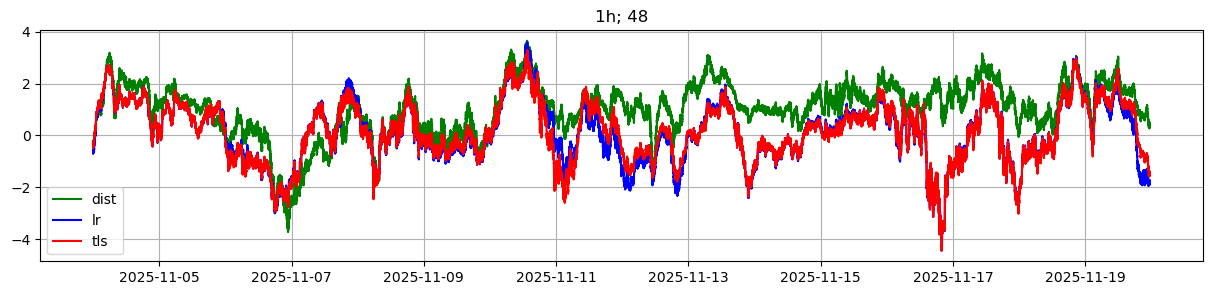

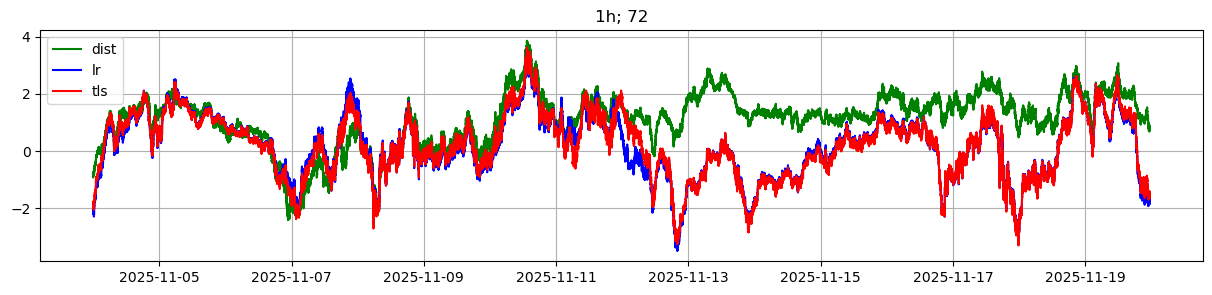

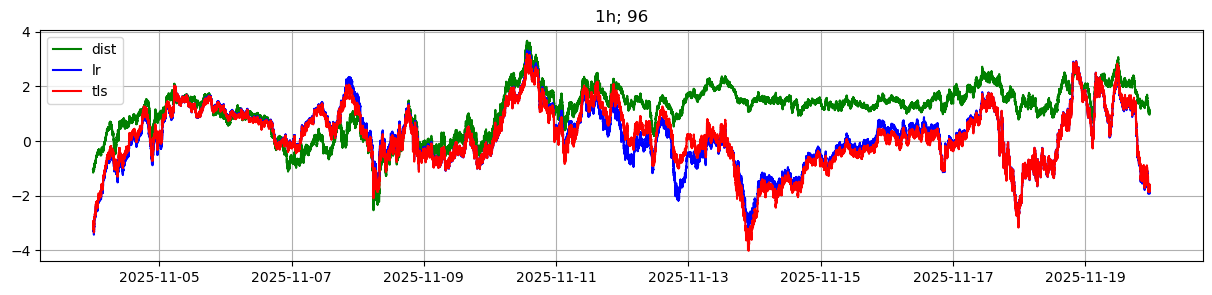

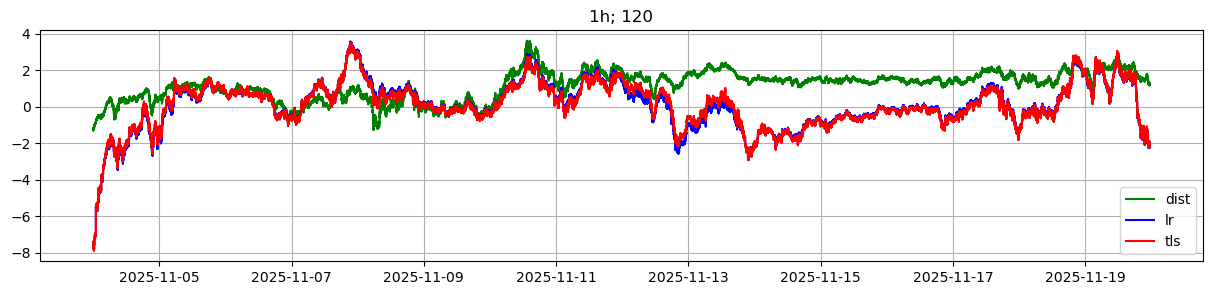

In [4]:
for tf, wind in search_space:
    plt.figure(figsize=(15, 3))
    plt.title(f'{tf}; {wind}')
    plt.plot(dist_df['time'], dist_df[f'z_score_{wind}_{tf}'], c='green', label='dist')
    plt.plot(lr_df['time'], lr_df[f'z_score_{wind}_{tf}'], c='blue', label='lr')
    plt.plot(tls_df['time'], tls_df[f'z_score_{wind}_{tf}'], c='red', label='tls')
    plt.grid()
    plt.legend()
    plt.show()

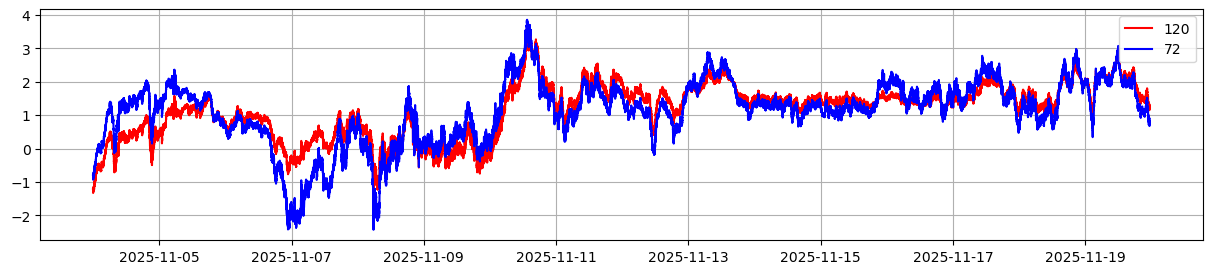

In [5]:
plt.figure(figsize=(15, 3))
plt.plot(dist_df['time'], dist_df['z_score_120_1h'], c='red', label='120')
plt.plot(dist_df['time'], dist_df['z_score_72_1h'], c='blue', label='72')
plt.legend()
plt.grid();

In [ ]:
plt.figure(figsize=(15, 3))
plt.plot(dist_df['time'], dist_df['spread_mean_72_1h'], c='black');

In [ ]:
dist_df['z_score_72_1h'].mean(), dist_df['z_score_72_1h'].std()

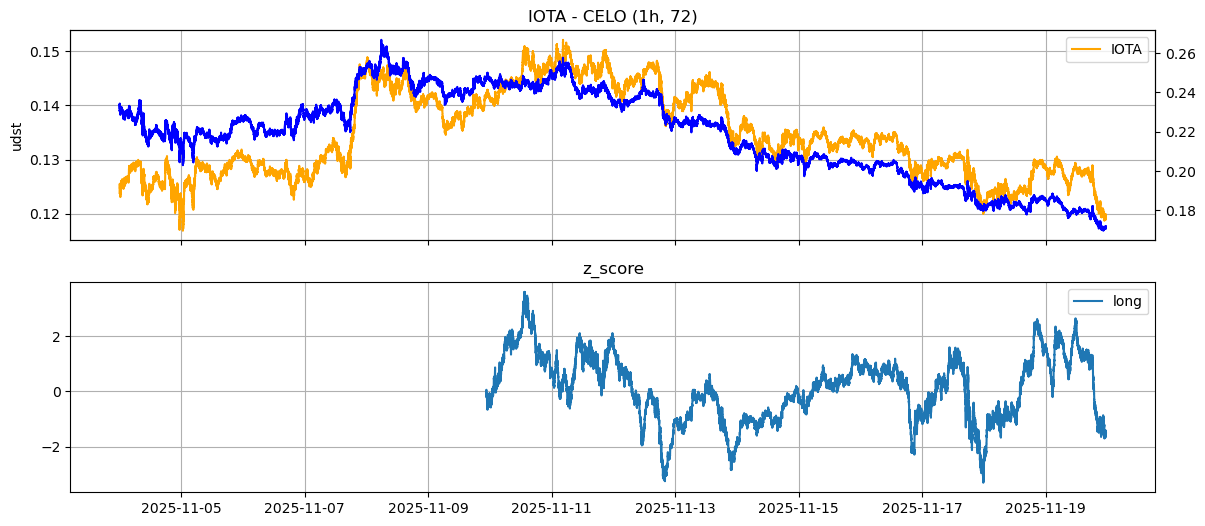

In [6]:
t = 720 * 24 * 10 #

tf = '1h'
wind = 72

# dist_df, lr_df, tls_df
df = tls_df.select('time', 'ts', token_1, token_2, f'{token_1}_size', f'{token_2}_size',
         f'{token_1}_bid_price', f'{token_1}_ask_price', f'{token_1}_bid_size', f'{token_1}_ask_size',
         f'{token_2}_bid_price', f'{token_2}_ask_price', f'{token_2}_bid_size', f'{token_2}_ask_size',
         f'z_score_{wind}_{tf}').rename({f'z_score_{wind}_{tf}': 'z_score'})
    

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6), sharex=True)
# --- Графики цены ---
ax1.plot(df.select('time'), df.select(token_1), label=token_1, color='orange')
ax1.set_title(f'{token_1} - {token_2} ({tf}, {wind})')

ax1.set_ylabel('udst')
ax1.legend()
ax1.grid()

ax4 = ax1.twinx()
ax4.plot(df.select('time'), df.select(token_2), label=token_2, color='blue')

# --- График z_score ---
ax2.plot(df.select('time')[-t:], df.select('z_score')[-t:], label='long');
ax2.set_title('z_score')
ax2.grid()
ax2.legend();

In [7]:
params = {'thresh_in': 2.5, 'thresh_out': 0.5}

leverage = 2

# double_lr_df
trades_df = backtest(df, token_1, token_2, dp_1, dp_2, ps_1, ps_2,
            thresh_low_in=-params['thresh_in'], thresh_high_in=params['thresh_in'],
            thresh_low_out=-params['thresh_out'], thresh_high_out=params['thresh_out'],
            long_possible=True, short_possible=True, dist_in=0, dist_out=0,
            balance=100, order_size=50, fee_rate=0.00055, stop_loss_std=5.0, sl_method='leave',
            sl_seconds = 60,
            leverage=leverage,
            verbose=2)
end_date = df['time'][-1]
metrics = analyze_strategy(trades_df, start_date=valid_time, end_date=end_date, initial_balance=200.0)

low_in: -2.5; high_in: 2.5; low_out: -0.5; high_out: 0.5. n_trades: 6.Profit: 15.08.
[ Open] 2025-11-08 05:44:25. Buy 681.8 IOTA, Sell 374.9 CELO
[Close] 2025-11-08 15:10:05. Profit: 4.54
[ Open] 2025-11-10 12:37:30. Sell 678.6 IOTA, Buy 406.8 CELO
[Close] 2025-11-11 06:21:30. Profit: 1.32
[ Open] 2025-11-12 18:39:05. Buy 701.4 IOTA, Sell 422.7 CELO
[Close] 2025-11-13 13:19:40. Profit: 6.79
[ Open] 2025-11-13 21:34:50. Buy 748.8 IOTA, Sell 472.9 CELO
[Close] 2025-11-15 06:56:40. Profit: 2.53
[ Open] 2025-11-17 22:33:05. Buy 818.1 IOTA, Sell 552.7 CELO
[Close] 2025-11-18 14:30:55. Profit: 1.05
[ Open] 2025-11-18 19:39:05. Sell 769.5 IOTA, Buy 535.8 CELO
[Close] 2025-11-19 18:57:00. Profit: -1.15


#### Анализ совершённых сделок

In [ ]:
orders = pl.read_ndjson('./logs/trades.jsonl')

token_1 = 'APT'
token_2 = 'FIL'

ot = "2025-09-16 17:07:14"
ct = "2025-09-16 23:09:17"

open_ = orders.filter((pl.col('token_1') == token_1) & (pl.col('token_2') == token_2) & (pl.col('action') == 'open') & (pl.col('ct') == ot))
close = orders.filter((pl.col('token_1') == token_1) & (pl.col('token_2') == token_2) & (pl.col('action') == 'close') & (pl.col('ct') == ct))

In [ ]:
open_.select('ct', 'token_1', 'token_2', 'tf', 'wind', 'thresh_in', 'thresh_out', 'side', 'action',
            't1_bid_price', 't1_ask_price', 't2_bid_price', 't2_ask_price', 'z_score', 'beta')

In [ ]:
close.select('ct', 'token_1', 'token_2', 'tf', 'wind', 'thresh_in', 'thresh_out', 'side', 'action',
            't1_bid_price', 't1_ask_price', 't2_bid_price', 't2_ask_price', 'z_score', 'beta')

In [ ]:
max_position_size = 200
leverage = 2
tf = open_['tf'][0]
wind = open_['wind'][0]

side = open_['side'][0]
side_2 = 'short' if side == 'long' else 'long'
beta = open_['beta'][0]
t1_open = open_['t1'].to_numpy()[0]
t2_open = open_['t2'].to_numpy()[0]
t1_close = close['t1'].to_numpy()[0]
t2_close = close['t2'].to_numpy()[0]

t1_op = open_['t1_ask_price'][0] if side == 'long' else open_['t1_bid_price'][0]
t2_op = open_['t2_bid_price'][0] if side == 'long' else open_['t2_ask_price'][0]
t1_cl = close['t1_bid_price'][0] if side == 'long' else close['t1_ask_price'][0]
t2_cl = close['t2_ask_price'][0] if side == 'long' else close['t2_bid_price'][0]

In [ ]:
make_zscore_df(pl.DataFrame({token_1: t1_open, token_2: t2_open}), token_1, token_2, wind, method='lr').tail(2)

In [ ]:
train_len = 80
wind = 10
winds = np.array((wind,))
tf = '4h'
median_length = 6
min_order = 50

train_time = datetime(2025, 9, 12, 17, 0, tzinfo=ZoneInfo("Europe/Moscow"))
start_time = datetime(2025, 9, 16, 17, 7, 14, tzinfo=ZoneInfo("Europe/Moscow"))
end_time = datetime(2025, 9, 16, 23, 9, 17, tzinfo=ZoneInfo("Europe/Moscow"))

start_ts = int(datetime.timestamp(start_time))

df_1 = db_manager.get_tick_ob(token=token_1 + '_USDT',
                                 start_time=train_time,
                                 end_time=end_time)
df_2 = db_manager.get_tick_ob(token=token_2 + '_USDT',
                                 start_time=train_time,
                                 end_time=end_time)

avg_df = make_df_from_orderbooks(df_1, df_2, token_1, token_2, start_time=train_time)
agg_df = make_trunc_df(avg_df, timeframe='4h', token_1=token_1, token_2=token_2, method='triple', offset='3h')

df_sec = make_trunc_df(avg_df, timeframe='1s', token_1=token_1, token_2=token_2,
                       start_date=start_time - timedelta(seconds=6),
                       end_date = end_time + timedelta(seconds=6),
                       method='last', return_bid_ask=True)
spread_df = create_zscore_df(token_1, token_2, df_sec, agg_df, winds, min_order, start_ts, median_length)

df = spread_df.select('time', 'ts', token_1, token_2, f'{token_1}_size', f'{token_2}_size',
     f'{token_1}_bid_price', f'{token_1}_ask_price', f'{token_1}_bid_size', f'{token_1}_ask_size',
     f'{token_2}_bid_price', f'{token_2}_ask_price', f'{token_2}_bid_size', f'{token_2}_ask_size',
     'z_score').filter(
        (pl.col('time') >= start_time) & (pl.col('time') <= end_time)
     )

In [ ]:
spread_df = create_zscore_df(token_1, token_2, df_sec, agg_df, winds, min_order, start_ts, median_length)


In [ ]:
t1_op, t1_cl

In [ ]:
t2_op, t2_cl

In [ ]:
qty_1, qty_2 = get_qty(token_1, token_2, t1_op, t2_op, beta, coin_information, max_position_size * leverage,
                          method='usdt_neutral')
qty_1, qty_2

In [ ]:
pr_1 = calculate_profit(open_price=t1_op, close_price=t1_cl, n_coins=qty_1, side=side)
pr_2 = calculate_profit(open_price=t2_op, close_price=t2_cl, n_coins=qty_2, side=side_2)
pr_1, pr_2, pr_1 + pr_2

In [ ]:
t1_op, t1_cp

In [ ]:
make_zscore_df(pl.DataFrame({token_1: t1_close, token_2: t2_close}), token_1, token_2, wind, method='lr').tail(1)

In [ ]:
qty_1 = 10881
qty_2 = 4375

open_spread = -0.000066
close_spread = 0.000021
open_mean = 0.000015
open_std = 0.00005

t1_bid_ask_spread = open_['t1_ask_price'][0] - open_['t1_bid_price'][0]
t2_bid_ask_spread = open_['t2_ask_price'][0] - open_['t2_bid_price'][0]
beta = open_['beta'][0]
z_score = open_['z_score'][0]
fee_rate = 0.00055

In [ ]:
# Доход за 1 стандартное отклонение
profit_per_std = qty_1 * open_std
profit_per_std

In [ ]:
# Считаем профит
spread_profit = abs(open_spread - (open_mean + 0.5 * open_std))
real_spread_profit = (close_spread - open_spread) * qty_1
spread_profit * qty_1, real_spread_profit

In [ ]:
# Комиссия за 4 сделки, каждая на 200$ (100$ с плечом 2)
fees = 4 * 200 * fee_rate

# Bid-ask spread
bid_ask_slippage = t1_bid_ask_spread * qty_1 + t2_bid_ask_spread * qty_2
fees, bid_ask_slippage

#### Обработка больших датафреймов

In [ ]:
from tqdm.notebook import tqdm
import polars as pl
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo
from bot.utils.files import load_config

config = load_config('./bot/config/config.yaml')

method = config['spr_method']
start_time = config['valid_time']
end_time = config['end_time']

In [ ]:
token_pairs = []
with open('./data/token_pairs.txt', 'r') as file:
    for line in file:
        a, b = line.strip().split()
        token_pairs.append((a, b))
len(token_pairs)

In [ ]:
# --- Создание объединённого датафрейма из нескольких ---
tfs = ('4h', '1h', )
method = 'dist'

time_series = pl.datetime_range(start=start_time, end=end_time, interval="5s", eager=True)
main_df = pl.DataFrame({'time': time_series})

for token_1, token_2 in tqdm(token_pairs):
    try:
        spread_df = pl.read_parquet(f'./data/pair_backtest/{token_1}_{token_2}_{method}_full.parquet', 
                low_memory=True, rechunk=True, use_pyarrow=True).filter(
                (pl.col('time') >= start_time) & (pl.col('time') < end_time)
            )

        cols_to_rn = [col for col in spread_df.columns for tf in tfs if col.endswith(tf)]
        prefix = f"{token_1}_{token_2}_"
        mapping = {c: f"{prefix}{c}" for c in cols_to_rn}
        spread_df = spread_df.rename(mapping)

        cols_to_drop = [col for col in spread_df.columns if col in main_df.columns]
        cols_to_drop.remove('time')
        spread_df = spread_df.drop(cols_to_drop)

        main_df = main_df.join(spread_df, on='time', how='full', coalesce=True)
    except FileNotFoundError:
        print(f'FileNotFoundError: {token_1} - {token_2}')
        continue

In [ ]:
spr_cols = [col for col in main_df.columns if 'spread' in col]

In [ ]:
main_df.drop(spr_cols)

In [ ]:
main_df[1:-1].drop(spr_cols).write_parquet('./data/train_data.parquet')

In [ ]:
# --- Код для склеивания по частям двух датафреймов, записанных на диске, в один ---
import polars as pl

df_1 = pl.read_parquet('./data/test_1.parquet', low_memory=True, use_pyarrow=True)
df_2 = pl.read_parquet('./data/test_2.parquet', low_memory=True, use_pyarrow=True)
print(df_1.shape, df_2.shape)

full_df = df_1.join(df_2[:, :500], on='time', how='full', coalesce=True)
full_df.write_parquet(f'./data/full_1.parquet')

cols_to_drop = df_2[:, :500].columns
cols_to_drop.remove('time')
df_2 = df_2.drop(cols_to_drop)
print(full_df.shape, df_2.shape)

df_2.write_parquet(f'./data/full_2.parquet')